### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!readlink -f .

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [4]:
import torch
import mubind as mb
import scanpy as sc

In [5]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus*

-rw-rw-r-- 1 ilibarra ilibarra 7.0M Aug  5 20:13 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus_use_logdynamic_0_obs2930.pth
-rw-rw-r-- 1 ilibarra ilibarra 8.6M Aug  5 20:13 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus_use_logdynamic_1_obs2930.pth
-rw-rw-r-- 1 ilibarra ilibarra 682M Aug  5 20:13 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus_sample_train_obs2930.h5ad
-rw-rw-r-- 1 ilibarra ilibarra  45M Aug  5 20:13 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus_train_dataloader_obs2930.pkl


In [6]:
# query
obs_id = 2930


# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'dentategyrus_use_logdynamic_%i_obs%s.pth' % (use_logdynamic, obs_id)
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

dentategyrus_use_logdynamic_0_obs2930.pth
dentategyrus_use_logdynamic_1_obs2930.pth


In [7]:
ad = sc.read_h5ad('dentategyrus_sample_train_obs%s.h5ad' % obs_id)
# ad = sc.read_h5ad('atac_train.h5ad')
#rna_sample = sc.read_h5ad('rna_sample_train.h5ad')
rna_sample = ad

In [8]:
rna_sample.shape

(2930, 13187)

In [9]:
import pickle
train = pickle.load(open('dentategyrus_train_dataloader_obs%s.pkl' % obs_id, 'rb'))

In [10]:
%load_ext line_profiler

In [11]:
# # load the pancreas multiome dataset
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')


In [12]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [13]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [14]:
import matplotlib.pyplot as plt

False
break


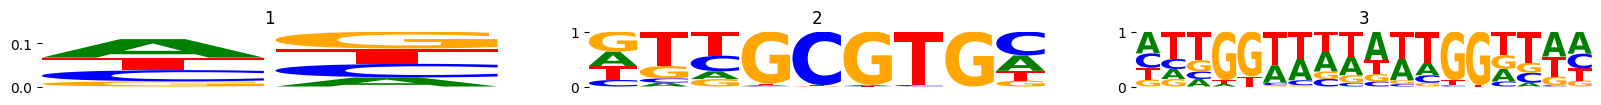

True
break


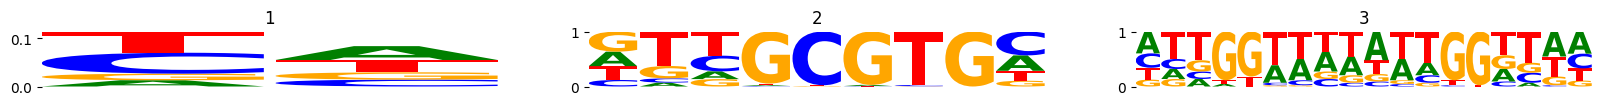

In [15]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


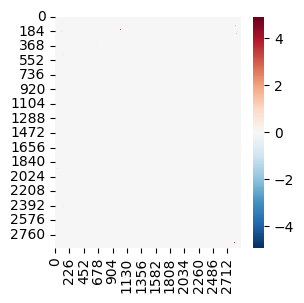

In [16]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [17]:
model = model_by_logdynamic[1]

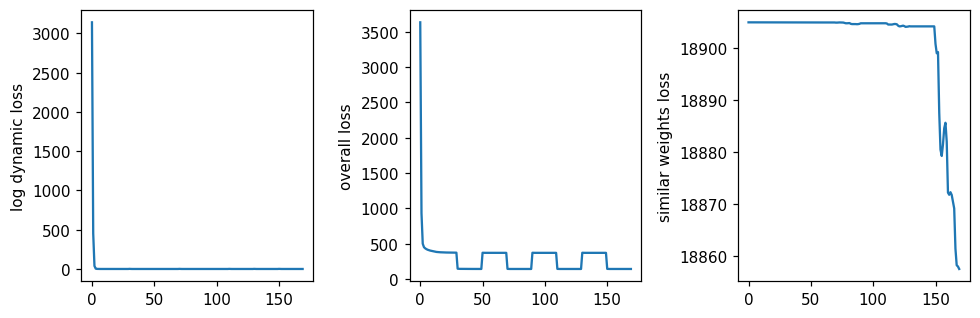

In [18]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np

False
True


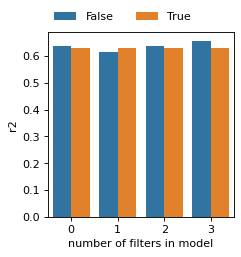

In [20]:
rcParams['figure.figsize'] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 3, 3
    rcParams['figure.dpi'] = 80
    ax = sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic', )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel('number of filters in model')
    plt.show()

In [21]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [22]:
ad.obs['dynamic_score'].describe()

count    2930.000000
mean        0.540680
std         0.053730
min         0.000000
25%         0.539971
50%         0.540680
75%         0.540709
max         1.000000
Name: dynamic_score, dtype: float64

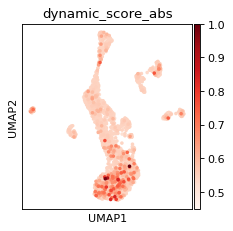

In [23]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

In [24]:
print('here...')

here...


In [25]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

plotting...
{'r2_counts': 0.628903865814209, 'r2_foldchange': -0.0014495849609375, 'r2_enr': -0.04714012145996094, 'r2_fc': 0.00046788969679425563, 'pearson_foldchange': 0.021630758118805167}


(array([  0.1,   1. ,  10. , 100. ]),
 [Text(0.1, 0, '$\\mathdefault{10^{-1}}$'),
  Text(1.0, 0, '$\\mathdefault{10^{0}}$'),
  Text(10.0, 0, '$\\mathdefault{10^{1}}$'),
  Text(100.0, 0, '$\\mathdefault{10^{2}}$')])

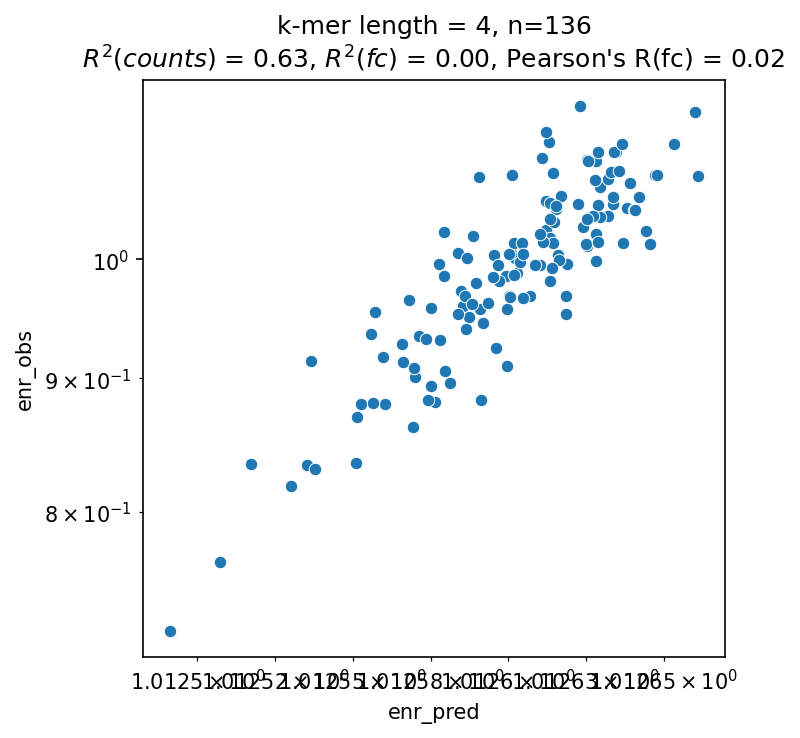

In [26]:
rcParams['pdf.fonttype'] = 42
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = 5, 5

# sns.set_context(rc={'axes.labelsize': 1})
k = 4
scores = mb.pl.kmer_enrichment(model, train, style='scatter', k=k, show=False, log_scale=True)
print(scores)
# g.set_xticklabels(rotation=30, ha='right')
plt.xticks(rotation=45, ha='right')
# # plt.show()

# plt.tight_layout()
# plt.savefig('../../../output/dentategyrus_kmer_predictions_%i.pdf' % k)
# plt.close()

In [27]:
!readlink -f ../../../output/dentategyrus_kmer_predictions.pdf

/home/ilibarra/workspace/theislab/mubind/output/dentategyrus_kmer_predictions.pdf


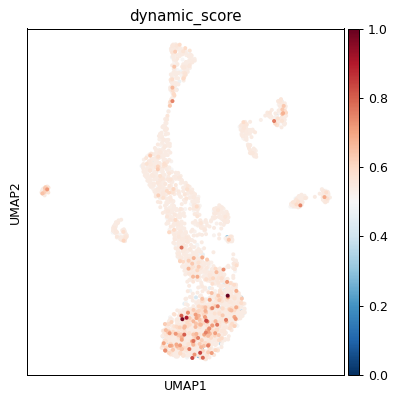

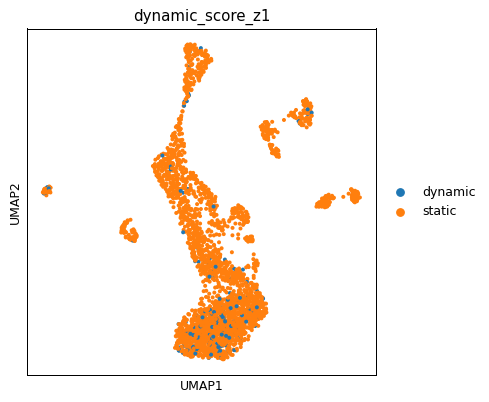

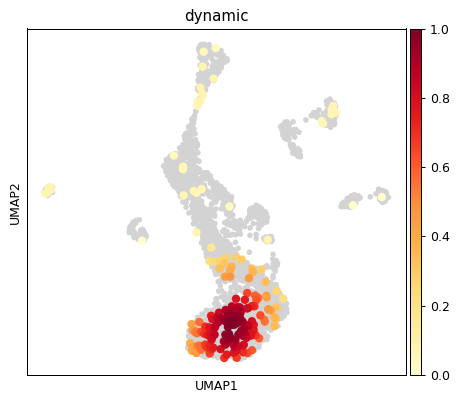

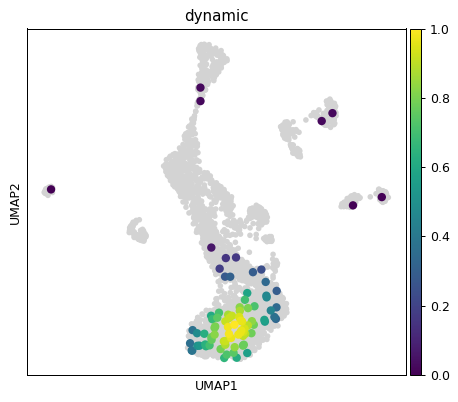

In [28]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

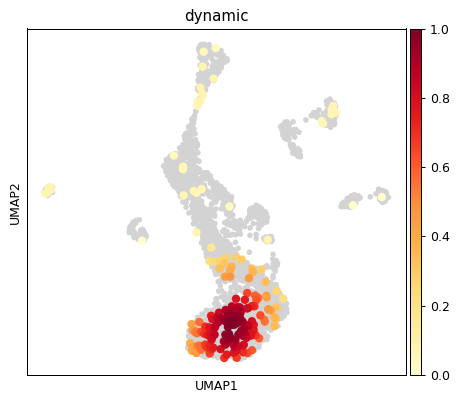

In [31]:
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic', save='dentategyrus_dynamic_red')

saving figure to file ./figures/scvelo_dentategyrus_dynamic.pdf


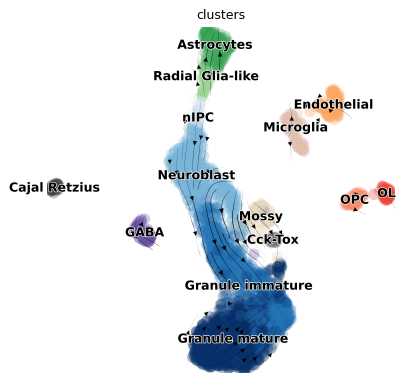

In [40]:
import scvelo as scv
scv.pl.velocity_embedding_stream(ad, save='dentategyrus_dynamic', arrow_size=.8, linewidth=.25)

<Axes: >

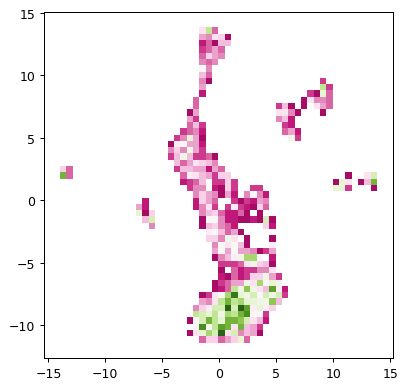

In [41]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

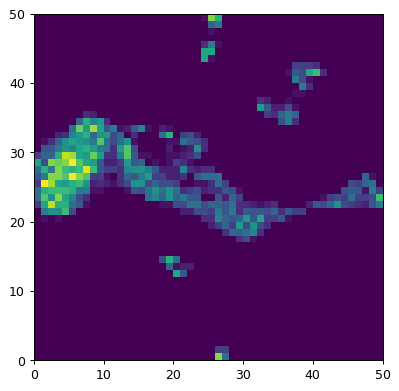

In [42]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [43]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [44]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


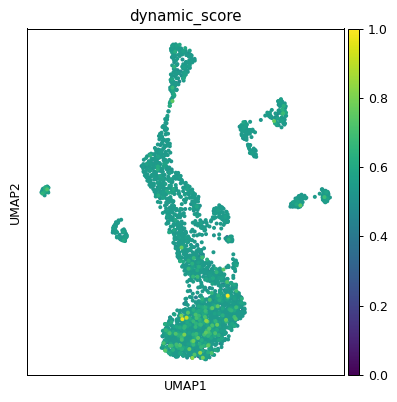

In [45]:
sc.pl.umap(ad, color='dynamic_score')

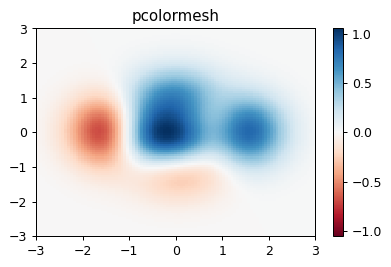

In [46]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [47]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [48]:
cell_type_key = 'clusters'

In [49]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs[cell_type_key].cat.codes.values, size_x=1, size_y=1)

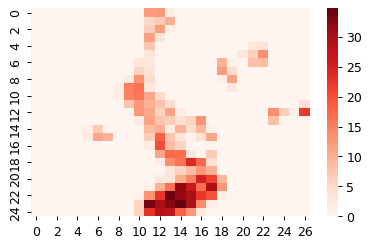

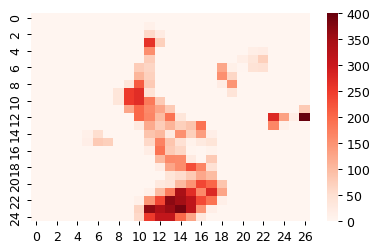

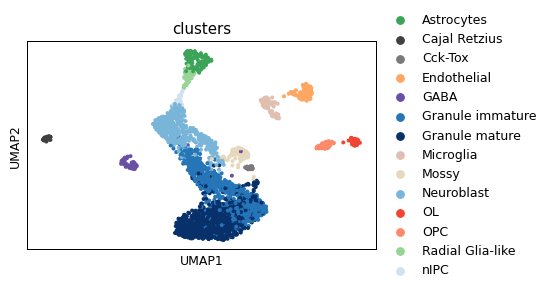

In [50]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color=cell_type_key)

In [51]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()


In [52]:
model = model_by_logdynamic[True]

In [53]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [54]:
# number of non_zero weights
len(G[G != 0])

62308

In [55]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [56]:
print('here...')

here...


In [57]:
ad

AnnData object with n_obs × n_vars = 2930 × 13187
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'n_counts', 'velocity_self_transition', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
    uns: 'clusters_colors', 'clusters_enlarged_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distance

In [58]:
model = model.cuda()

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# device

In [60]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [61]:
train

In [62]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'

        
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
(128, 2930)
2856046800000.0
here...
(128, 2930)
2353553000000.0
here...
(128, 2930)
1396651700000.0
here...
(128, 2930)
1563507800000.0
here...
(128, 2930)
2185263300000.0
here...
(128, 2930)
2274207500000.0
here...
(128, 2930)
2094323600000.0
here...
(128, 2930)
1651934200000.0
here...
(128, 2930)
2181155100000.0
here...
(128, 2930)
3143311000000.0
here...
(128, 2930)
2227194300000.0
here...
(128, 2930)
3339283300000.0
here...
(128, 2930)
1831032800000.0
here...
(128, 2930)
1814699600000.0
here...
(128, 2930)
2477105600000.0
here...
(128, 2930)
1907320800000.0
here...
(128, 2930)
2868307600000.0
here...
(128, 2930)
2056490200000.0
here...
(128, 2930)
2661629600000.0
here...
(128, 2930)
1678149400000.0
here...
(128, 2930)
1242123700000.0
here...
(128, 2930)
1851048300000.0
here...
(114, 2930)
2316472200000.0


In [63]:
import scvelo as scv

In [64]:
ad.shape, binding_scores.shape

((2930, 13187), (2930, 2930))

In [65]:
binding_scores

array([[7349828. , 7286087. , 7234309. , ..., 7125250. , 6769667.5,
        7019276.5],
       [7282303.5, 7180440.5, 7143005. , ..., 6988419. , 6666299. ,
        6872696.5],
       [7320444. , 7240102.5, 7192665. , ..., 7035899. , 6707566.5,
        6925640.5],
       ...,
       [7303637. , 7216828. , 7173559.5, ..., 7046850.5, 6711989. ,
        6936129.5],
       [7250796. , 7156067.5, 7115549.5, ..., 6989981. , 6670038. ,
        6879278. ],
       [7307043. , 7205868. , 7167688. , ..., 7001323. , 6678960.5,
        6888087. ]], dtype=float32)

In [66]:
# ad
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [67]:
np.random.shuffle(binding_scores)
binding_scores

array([[7323232. , 7227626.5, 7190169. , ..., 7096780.5, 6762414. ,
        6995179. ],
       [7290506.5, 7187533.5, 7150198. , ..., 7002432. , 6680542. ,
        6890408.5],
       [7315332. , 7218604. , 7178159.5, ..., 7024021.5, 6705326.5,
        6919555.5],
       ...,
       [7310829. , 7237692. , 7186746. , ..., 7065545.5, 6724169. ,
        6949687. ],
       [7292523.5, 7213102.5, 7166607. , ..., 7041639. , 6705236. ,
        6928228.5],
       [7241585. , 7127106. , 7094303. , ..., 6952339. , 6644497. ,
        6841124.5]], dtype=float32)

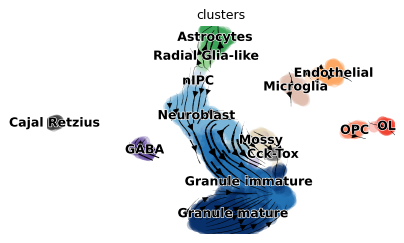

In [68]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key)
except Exception:
    print("sample too small.")

In [69]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

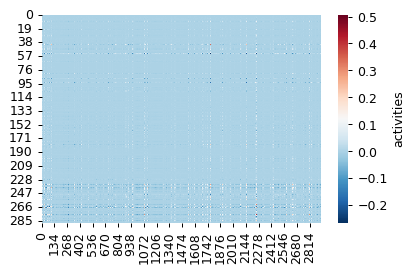

In [70]:
import seaborn as sns
act = model.get_log_activities().detach().cpu().squeeze(0)
sns.heatmap(act, cmap='RdBu_r', cbar_kws={'label': 'activities'})

In [71]:
# anno[anno['Name'] == 'NR/20']

In [72]:
# clu[clu['Cluster_ID'] == 248]

tensor([ 94, 179, 240, 252, 256,  93,  41, 285,  53, 265, 263, 239, 235, 267,
        276])


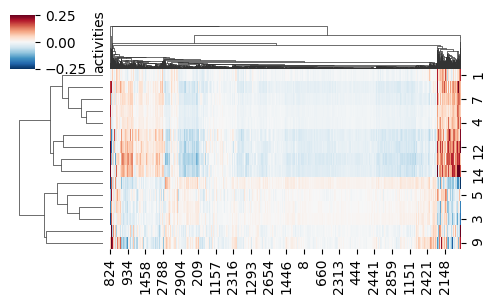

In [73]:
# highlight the top-n filters per cell, with the top variability
rcParams['figure.dpi'] = 100
n_show = 15
print(act.var(axis=1).sort()[1][-n_show:])
act_sel = act[act.var(axis=1).sort()[1][-n_show:],:]
vmax = act_sel.abs().max()
sns.clustermap(act_sel,
               vmin=-vmax / 2, vmax=vmax / 2,
               cmap='RdBu_r',
               
               cbar_kws={'label': 'activities'},
               figsize=[5, 3])


In [74]:
rna_sample.layers['velocity'].shape, rna_sample.shape

((2930, 13187), (2930, 13187))

In [75]:
# scv.pl.velocity_graph(rna_sample)

In [76]:

# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [77]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [78]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [79]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 2930 × 13187
     obs: 'clusters', 'age(days)', 'clusters_enlarged', 'n_counts', 'velocity_self_transition', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
     var: 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
     uns: 'clusters_colors', 'clusters_enlarged_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
     obsm: 'X_pca', 'X_umap', 'velocity_umap'
     varm: 'PCs'
     layers: 'Ms', 'Mu', 'ambiguous', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
     obsp: 'connectivities', '

In [80]:
rna_sel = rna_sample # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(2930, 13187)

In [81]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [82]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

anno = mb.datasets.archetypes_anno()

In [83]:
rna_sel.shape
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


In [84]:
ad.obs

,clusters,age(days),clusters_enlarged,n_counts,velocity_self_transition,dynamic_score,dynamic_score_cluster,dynamic_score_z1,dynamic_score_z2,dynamic_score_abs,umap_density_dynamic_score_z1,umap_density_dynamic_score_z2
index,,,,,,,,,,,,
AAACATACCCATGA,Granule immature,35,Granule-immature,2460.500000,0.051353,0.240400,static,static,static,0.240400,0.904131,0.889691
AAACATACCGTAGT,Radial Glia-like,12,Radial Glia-like,2460.499756,0.220968,0.365605,static,static,static,0.365605,0.130252,0.120899
AAACATACGAGAGC,Granule mature,35,Granule-mature,2460.499756,0.069691,0.791789,dynamic,dynamic,dynamic,0.791789,0.674206,0.614487
AAACATACTGAGGG,Granule immature,12,Granule-immature,2460.500000,0.080728,0.592427,dynamic,static,static,0.592427,0.333817,0.308805
AAACATTGGCATCA,Granule immature,35,Granule-immature,2460.500000,0.119560,0.569801,dynamic,static,static,0.569801,0.909646,0.901201
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCTACTTCCCGT,Granule immature,35,Granule-immature,2460.500000,0.034482,0.536359,static,static,static,0.536359,0.397510,0.374104
TTTGACTGCCTGTC,Neuroblast,12,Neuroblast 2,2460.499756,0.131426,0.532400,static,static,static,0.532400,0.295933,0.274872
TTTGACTGTCTGGA,Granule mature,35,Granule-mature,2460.499756,0.100035,0.626570,dynamic,dynamic,static,0.626570,0.854801,0.758780


False


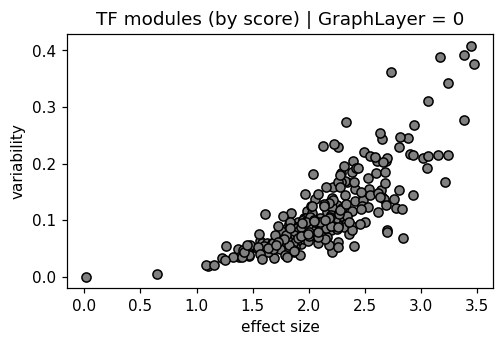

True


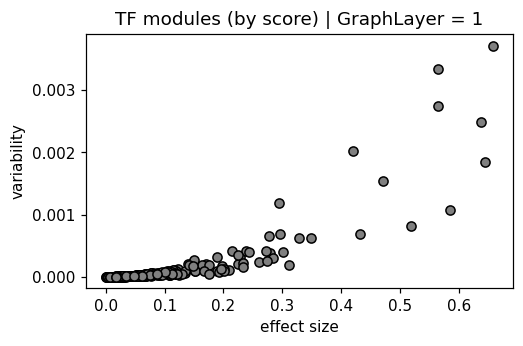

In [87]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm["mubind_activities"] = log_act

    mb.pl.set_rcParams({"figure.figsize": [5, 3], "figure.dpi": 110})
    delta = log_act.max(axis=0) - log_act.min(axis=0)
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color="gray", edgecolors="black")
    plt.xlabel("effect size")
    plt.ylabel("variability")
    plt.title("TF modules (by score) | GraphLayer = %i" % optimize_log_dynamic)
    plt.show()

In [88]:
# unique names for annotation
names = anno['Name'] # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + '_%i' % added[name])
        added[name] += 1
anno['Name_unique'] = new_name


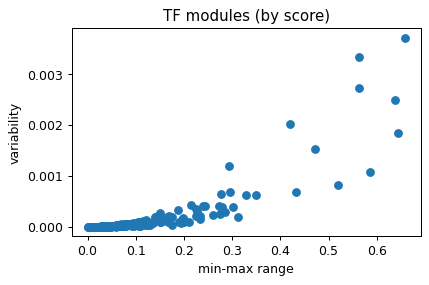

In [90]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])



In [91]:

# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ['max_effect', 'variability']
meta['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta['archetypes_name'] = meta['name'].map(anno.set_index('Cluster_ID')['Name_unique'])
meta['archetypes_name'] = np.where(pd.isnull(meta['archetypes_name']), meta['name'], meta['archetypes_name'])

meta['archetypes_seed'] = meta['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])

meta['filter_position'] = range(0, meta.shape[0])

In [92]:
meta = meta.sort_values('max_effect', ascending=0)
meta

res = res.merge(meta, left_on='archetype_id', right_on='name')
res = res.sort_values('p_val', ascending=True)

In [93]:
name_by_filter_id = meta['archetypes_name'].to_dict()
# name_by_filter_id

## Observe general scores per case

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

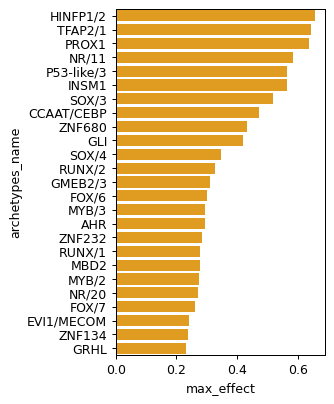

In [94]:
rcParams['figure.figsize'] =3, 5
sns.barplot(data=res.sort_values('max_effect', ascending=False).head(25), x='max_effect', y='archetypes_name', color='orange')

In [95]:
res

,opt_log_dynamic,archetype_id,spearman,p_val,max_effect,variability,name,archetypes_name,archetypes_seed,filter_position
191,True,190,-0.076029,0.000038,0.024365,2.065874e-06,190,SOX/6,SOX10_HMG_2,191
93,True,92,0.074626,0.000053,0.518763,8.181830e-04,92,SOX/3,SOX10_HMG_4,93
24,True,23,-0.066684,0.000304,0.048784,7.841250e-06,23,CPEB1,CPEB1_RRM_1,24
260,True,259,-0.063663,0.000565,0.075365,2.336398e-05,259,TFCP2,TF2L1_MOUSE.H11MO.0.C,260
4,True,3,-0.063177,0.000622,0.008669,3.192534e-07,3,HD/3,VENTX_homeodomain_2,4
...,...,...,...,...,...,...,...,...,...,...
122,True,121,0.001143,0.950702,0.024825,1.376122e-06,121,ZNF354,Z354A_HUMAN.H11MO.0.C,122
51,True,50,-0.001060,0.954259,0.036326,3.853280e-06,50,CREB/ATF/2,ATF7_MA0834.1,51
214,True,213,0.001000,0.956844,0.035054,2.194194e-06,213,ZNF524,ZNF524_C2H2_1,214
35,True,34,0.000572,0.975297,0.050917,8.763278e-06,34,NR/5,THRA_nuclearreceptor_1,35


break


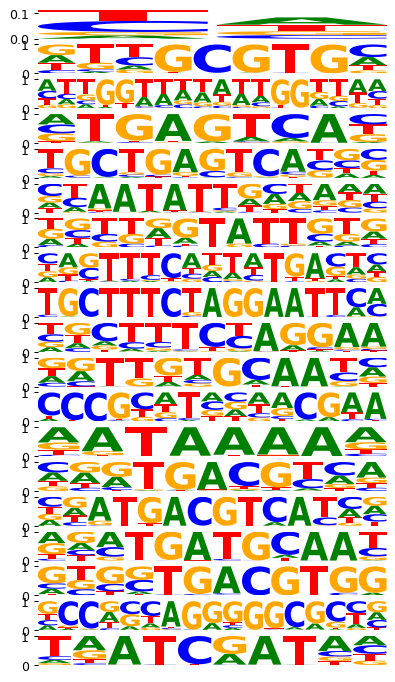

In [96]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

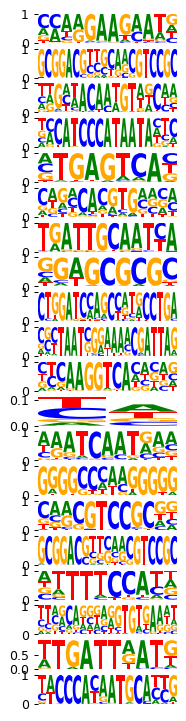

<Figure size 180x1800 with 0 Axes>

In [97]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [98]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 2.439512


In [99]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [100]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [101]:
def find_varname(ad, k, shuffle=False):
    if not shuffle:
        return ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
    else:
        ad_sel = ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
        return pd.Series(ad.var_names).sample(ad_sel.shape[0]).values

In [102]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [104]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')


False
True


In [108]:

def get_act_gene_corr(model_by_logdynamic,
                      shuffle=False,
                      random_state=0,
                      query_cluster_id=None):
    print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
    res = []
    # print(len(all_targets))

    rna_sel_df = rna_sel.to_df()

    for optimize_log_dynamic in model_by_logdynamic:
        print('use GraphLayer = %i' % optimize_log_dynamic)
        model = model_by_logdynamic[optimize_log_dynamic]

        log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
        log_act = pd.DataFrame(log_act.detach().cpu().numpy())
        log_act.index = ad.obs_names

        ad.obsm['log_activities'] = log_act
        ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

        if shuffle:
            random_cols = ad.obsm['log_activities'].iloc[:,2:].columns.values
            np.random.shuffle(random_cols)
            # random_cols
        
        for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
            next_log_act = ad.obsm['log_activities'][k].values

            # if shuffle:
            #     next_log_act = ad.obsm['log_activities'][random_cols[ki]].values
            
            # print(ki)
            # if ki % 30 == 0:
            #     print(ki)
            if query_cluster_id is not None and k != query_cluster_id:
                continue
            
            names = set()
            clu_sel = clu[clu['Cluster_ID'] == k]['Motif']

            for g in clu_sel:
                names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
            for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
                names.add(g.split('_')[0].split('.')[0])
            # print(k, names)
            next_targets = set()
            for name in names:
                if len(name) <= 2:
                    continue
                target = find_varname(rna_sel, name, shuffle=shuffle)
                # print(name, target)
                for t in target:
                    next_targets.add(t)

            # for t in all_targets:
            for t in set(all_targets).intersection(next_targets):
                gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
                assert gex.shape[1] == 1
                gex = gex.flatten()
                # print(next_log_act.shape, gex.shape)
                # print(t, pearsonr(next_log_act, gex))
                res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                        list(spearmanr(next_log_act, gex)))
                
    res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

    # p-values
    res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
    res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])
    
    # p-val adjust
    from statsmodels.stats.multitest import fdrcorrection
    res['p_adj'] = fdrcorrection(res['p_val'])[1]
    return res


In [109]:
anno[anno['Name'] == 'NR/20']

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size,Name_unique
145,248,NR/20,nuclearreceptor,ANDR_MOUSE.H11MO.0.A,17,2,16,13,NR/20


In [110]:
res = get_act_gene_corr(model_by_logdynamic) #  query_cluster_id=248)
shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i, query_cluster_id=69) for i in range(10)]


association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLa

In [111]:
res

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
0,0,False,1,Lhx6,True,0.003881,0.833671,HD/1,0.928214
1,1,False,2,Emx2,True,-0.021974,0.234416,HD/2,0.382166
2,1,False,2,Dlx1,True,-0.013717,0.457973,HD/2,0.628372
3,1,False,2,Lhx6,True,-0.023791,0.197949,HD/2,0.334252
4,1,False,2,Dlx5,True,-0.039445,0.032758,HD/2,0.083405
...,...,...,...,...,...,...,...,...,...
1459,277,True,278,Gmeb2,True,0.017925,0.332067,GMEB2/3,0.495347
1460,280,True,281,Pax6,True,-0.058318,0.001588,PAX/1,0.006789
1461,280,True,281,Pax6os1,True,-0.027405,0.138059,PAX/1,0.255201
1462,283,True,284,Ahr,True,0.011032,0.550544,AHR,0.711291


In [112]:
res = get_act_gene_corr(model_by_logdynamic)
shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i) for i in range(10)]

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLa

In [113]:
table = []
for use_graph in [False, True]:
    for thr in range(1, 10):
        sel = res[res['opt_log_dynamic'] == use_graph]
        next_thr = 10 ** (-thr)
        n_pos = sel[sel['p_adj'] < next_thr].shape[0]
        n_neg = [s[(s['p_adj'] < next_thr) & (s['opt_log_dynamic'] == use_graph)].shape[0] for s in shuffled]
        # print(next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg))
        table.append([next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg), use_graph])
table = pd.DataFrame(table, columns=['p_adj_thr', 'n_pos', 'mu', 'sigma', 'zscore', 'graph_layer'])
table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore')

p_adj_thr,1.000000e-09,1.000000e-08,1.000000e-07,1.000000e-06,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01
graph_layer,,,,,,,,,
False,17.060107,16.931821,16.909936,23.185106,32.301258,29.911232,29.329282,41.644077,42.534653
True,12.621635,12.593050,18.507256,19.729753,22.747781,29.313381,31.304952,32.753934,36.483341


Text(0.5, 1.0, 'associations between activity layer and TF (GEX)')

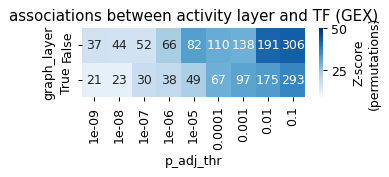

In [114]:
rcParams['figure.figsize'] = 4, 1
hm = table.pivot(index='graph_layer', columns='p_adj_thr', values='n_pos').fillna(0)
z = table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore').fillna(0)
sns.heatmap(z, annot=hm, fmt='', cmap='Blues', cbar_kws={'label': 'Z-score\n(permutations)'},
            vmin=9,
            vmax=50)
plt.title('associations between activity layer and TF (GEX)')

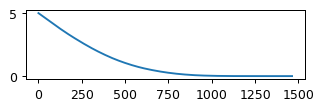

In [115]:
cumulative = np.cumsum(res.sort_values('p_adj')['p_adj']) / 100
plt.plot(range(len(cumulative)), cumulative[::-1])

In [116]:
shuffled[0].sort_values('p_val')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
53,162,False,284,Tmem38a,True,0.189496,4.325992e-25,AHR,9.430663e-23
30,103,False,165,Tmed3,True,0.149529,4.077543e-16,RBPJ,4.444522e-14
125,80,True,113,Mycl,True,0.138851,4.374617e-14,GC-tract,3.178888e-12
10,48,False,87,Meis2,True,0.127956,3.605791e-12,FOX/6,1.965156e-10
187,203,True,36,Hlf,True,0.119320,9.225166e-11,NR/7,4.022172e-09
...,...,...,...,...,...,...,...,...,...
133,91,True,58,Irf8,True,NaN,1.000000e+00,Ebox/CACGTG/1,1.000000e+00
116,64,True,98,Art3,True,NaN,1.000000e+00,ETS/1,1.000000e+00
167,149,True,45,Tbc1d1,True,NaN,1.000000e+00,NR/16,1.000000e+00
211,266,True,112,Tbc1d1,True,NaN,1.000000e+00,KLF/SP/1,1.000000e+00


In [117]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
543,127,False,128,Nfia,True,0.243690,7.152633e-41,NFI/3,4.403068e-38
139,48,False,49,Fos,True,0.243386,9.022680e-41,CREB/ATF/1,4.403068e-38
356,88,False,89,Sox4,True,0.244228,4.743278e-41,SOX/1,4.403068e-38
235,58,False,59,Mycn,True,0.230975,8.795235e-37,Ebox/CACGTG/2,3.219056e-34
276,67,False,68,Id4,True,0.215758,3.333383e-32,Ebox/CACCTG,9.760147e-30
...,...,...,...,...,...,...,...,...,...
843,44,True,45,Rxrb,True,0.000601,9.740748e-01,NR/16,1.000000e+00
846,44,True,45,Thbs3,True,0.000092,9.960389e-01,NR/16,1.000000e+00
861,45,True,46,Ppargc1a,True,NaN,1.000000e+00,NR/17,1.000000e+00
880,49,True,50,Atf7,True,NaN,1.000000e+00,CREB/ATF/2,1.000000e+00


In [118]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
# res[res['p_adj'] < 0.1]

In [119]:
genes_by_module_name = res.groupby(['module_name'])['gene_name'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
# genes_by_module_name

In [120]:
res[res['gene_name'] == 'Malat1']

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj


In [121]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
543,127,False,128,Nfia,True,0.243690,7.152633e-41,NFI/3,4.403068e-38
139,48,False,49,Fos,True,0.243386,9.022680e-41,CREB/ATF/1,4.403068e-38
356,88,False,89,Sox4,True,0.244228,4.743278e-41,SOX/1,4.403068e-38
235,58,False,59,Mycn,True,0.230975,8.795235e-37,Ebox/CACGTG/2,3.219056e-34
276,67,False,68,Id4,True,0.215758,3.333383e-32,Ebox/CACCTG,9.760147e-30
...,...,...,...,...,...,...,...,...,...
843,44,True,45,Rxrb,True,0.000601,9.740748e-01,NR/16,1.000000e+00
846,44,True,45,Thbs3,True,0.000092,9.960389e-01,NR/16,1.000000e+00
861,45,True,46,Ppargc1a,True,NaN,1.000000e+00,NR/17,1.000000e+00
880,49,True,50,Atf7,True,NaN,1.000000e+00,CREB/ATF/2,1.000000e+00


In [122]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [123]:
df2

opt_log_dynamic,False,True
k,,
Ahr_284,0.006393,0.011032
Ap2a1_264,0.083824,0.006813
Ap2a2_264,0.134813,0.045443
Ap2b1_264,0.102018,0.044073
Arid3a_24,-0.042556,-0.004621
...,...,...
Zic1_110,-0.058097,0.004931
Zic1_273,-0.079573,-0.013797
Zic2_273,-0.008657,-0.013349


In [124]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)


In [125]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [126]:
# res['arch_name'] = name_by_filter_id

In [127]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
543,127,False,128,Nfia,True,0.243690,7.152633e-41,NFI/3,4.403068e-38,Nfia_128
139,48,False,49,Fos,True,0.243386,9.022680e-41,CREB/ATF/1,4.403068e-38,Fos_49
356,88,False,89,Sox4,True,0.244228,4.743278e-41,SOX/1,4.403068e-38,Sox4_89
235,58,False,59,Mycn,True,0.230975,8.795235e-37,Ebox/CACGTG/2,3.219056e-34,Mycn_59
276,67,False,68,Id4,True,0.215758,3.333383e-32,Ebox/CACCTG,9.760147e-30,Id4_68
...,...,...,...,...,...,...,...,...,...,...
843,44,True,45,Rxrb,True,0.000601,9.740748e-01,NR/16,1.000000e+00,Rxrb_45
846,44,True,45,Thbs3,True,0.000092,9.960389e-01,NR/16,1.000000e+00,Thbs3_45
861,45,True,46,Ppargc1a,True,NaN,1.000000e+00,NR/17,1.000000e+00,Ppargc1a_46
880,49,True,50,Atf7,True,NaN,1.000000e+00,CREB/ATF/2,1.000000e+00,Atf7_50


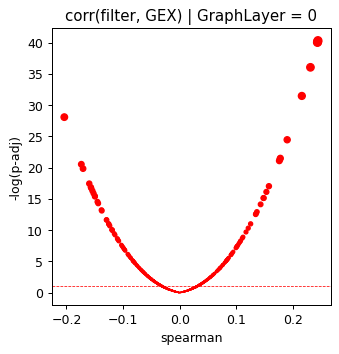

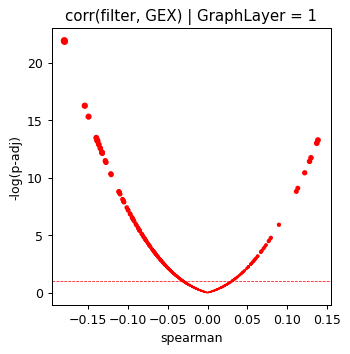

In [128]:
rcParams['figure.figsize'] = 4, 4
rcParams['figure.dpi'] = 90

for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 1), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('corr(filter, GEX) | GraphLayer = %i' % optimize_log_dynamic)
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

<Axes: xlabel='spearman', ylabel='Count'>

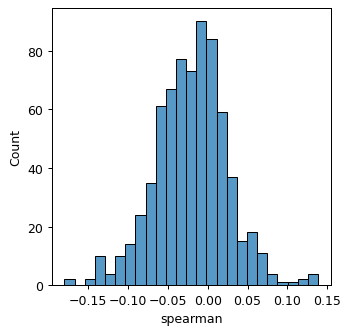

In [129]:
sns.histplot(grp['spearman'])

In [130]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

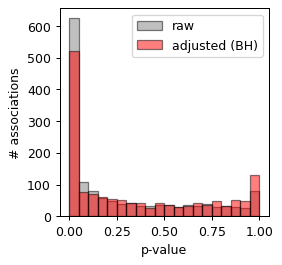

In [131]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 90
plt.hist(res['p_val'], color='gray', bins=20, label='raw', alpha=.5, edgecolor = 'black')
plt.hist(res['p_adj'], color='red', bins=20, label='adjusted (BH)', alpha=.5, edgecolor = 'black')
plt.xlabel('p-value')
plt.legend()
plt.ylabel('# associations')

In [132]:
res[res['p_adj'] < 0.05]

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
8,1,False,2,Lhx2,True,-0.089777,0.000001,HD/2,0.000012,Lhx2_2
11,1,False,2,Prrx2,True,-0.053156,0.004000,HD/2,0.014827,Prrx2_2
18,1,False,2,Emx1,True,-0.050537,0.006216,HD/2,0.021465,Emx1_2
20,1,False,2,Meox1,True,-0.043850,0.017610,HD/2,0.049578,Meox1_2
22,1,False,2,Dlx2,True,-0.044838,0.015214,HD/2,0.043932,Dlx2_2
...,...,...,...,...,...,...,...,...,...,...
1444,261,True,262,Zbtb7c,True,-0.044695,0.015541,GLI,0.044437,Zbtb7c_262
1448,263,True,264,Ap2b1,True,0.044073,0.017043,TFAP2/1,0.048167,Ap2b1_264
1449,263,True,264,Ap2a2,True,0.045443,0.013893,TFAP2/1,0.041289,Ap2a2_264
1451,265,True,266,Insm1,True,-0.050142,0.006633,INSM1,0.022635,Insm1_266


In [133]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [134]:
log_act = ad.obsm['log_activities'].copy()

In [135]:
cols_act = ['intercept', 'dinuc_bias'] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [136]:
import anndata
ad_act = anndata.AnnData(log_act)
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

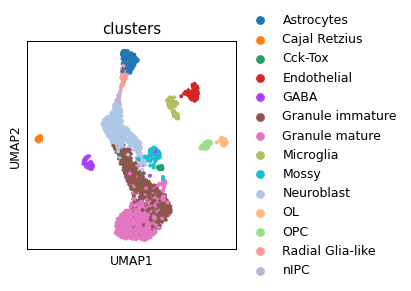

In [137]:
sc.pl.umap(ad_act, color=cell_type_key)


Rank genes groups using the annotation

In [138]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)
rkg_df = []
for ct in ad_act.obs[cell_type_key].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2[cell_type_key] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

Granule immature
Radial Glia-like
Granule mature
Neuroblast
Microglia
Cajal Retzius
OPC
Cck-Tox
GABA
Endothelial
Astrocytes
OL
Mossy
nIPC


,names,scores,logfoldchanges,pvals,pvals_adj,clusters,module_name
0,SOX/1,13.993413,NaN,2.453977e-42,7.067453e-40,Granule immature,SOX/1
1,ZKSCAN1,12.138745,NaN,1.373464e-32,9.888943e-31,Granule immature,ZKSCAN1
2,OVOL1,11.670671,NaN,1.838188e-30,6.617477e-29,Granule immature,OVOL1
3,ZNF431,11.298390,NaN,1.136821e-28,2.976403e-27,Granule immature,ZNF431
4,NR/3,11.296875,NaN,1.425543e-28,3.421303e-27,Granule immature,NR/3


Get top modules

In [139]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

In [140]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)

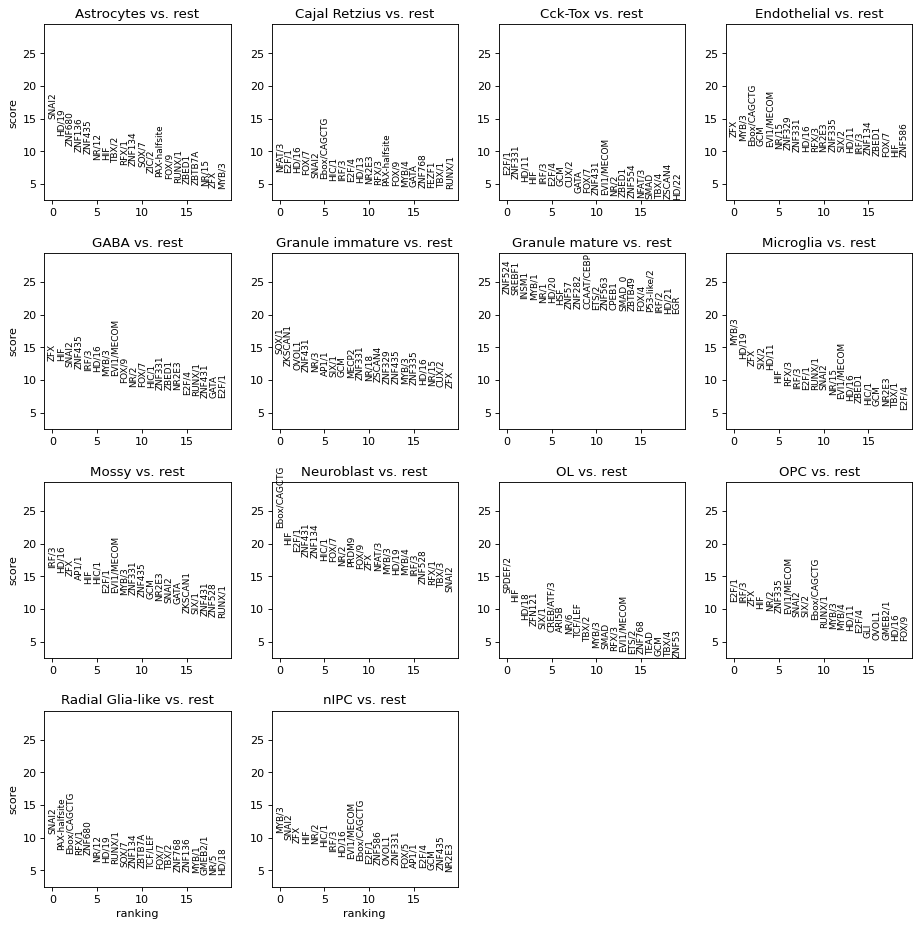

In [141]:
rcParams['figure.figsize'] = 3.5, 3.5
rcParams['figure.dpi'] = 80
sc.pl.rank_genes_groups(ad_act)


In [142]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Ap2a2_264',
 'Ap2b1_264',
 'Arnt2_58',
 'Arxes1_2',
 'Arxes1_8',
 'Atf2_49',
 'Atf4_51',
 'Bach2_53',
 'Cpeb1_23',
 'Creb1_49',
 'Creb3_50',
 'Dbpht2_52',
 'E2f1_156',
 'E2f3_156',
 'Elk1_98',
 'Emx1_7',
 'Ergic1_98',
 'Ergic2_96',
 'Ets1_98',
 'Etv3_98',
 'Fos_49',
 'Fosb_49',
 'Foxj3_80',
 'Foxk2_79',
 'Foxo1_77',
 'Foxq1_80',
 'Gata2_242',
 'Grhl1_258',
 'Hes1_59',
 'Id4_68',
 'Irf2bp2_104',
 'Jun_54',
 'Junb_50',
 'Junb_54',
 'Jund_49',
 'Klf6_109',
 'Lef1_29',
 'Maf1_55',
 'Mafb_55',
 'Maff_55',
 'Mafk_55',
 'Mef2a_183',
 'Mgat1_71',
 'Mgat1_73',
 'Mgat3_71',
 'Mgat3_73',
 'Mgat4b_71',
 'Mgat4b_73',
 'Mgat4c_71',
 'Mgat4c_73',
 'Mgat5b_71',
 'Mgat5b_73',
 'Mlx_58',
 'Mycl_59',
 'Mycn_59',
 'Neurog2_62',
 'Nfe2l1_54',
 'Nfe2l2_53',
 'Nfia_128',
 'Nfia_188',
 'Nfia_189',
 'Nfix_189',
 'Nfya_13',
 'Nr1h2_30',
 'Nr2e1_43',
 'Nr2f1_30',
 'Nr2f1_41',
 'Nr2f1_42',
 'Nr3c2_248',
 'Olig1_62',
 'Pbx1_12',
 'Pbx1_21',
 'Pou6f1_2',
 'Rell2_160',
 'Rfx3_247',
 'Runx1t1_179',
 'Smad3_129',
 '

In [143]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
766,11,True,12,Pbx1,True,-0.149060,5.044511e-16,HD/12,2.954066e-14,Pbx1_12
29,6,False,7,Emx1,True,-0.145162,2.878569e-15,HD/7,1.505080e-13,Emx1_7
32,7,False,8,Arxes1,True,-0.138045,6.138845e-14,HD/8,2.567791e-12,Arxes1_8
34,11,False,12,Pbx1,True,-0.129060,2.343838e-12,HD/12,6.862757e-11,Pbx1_12
764,7,True,8,Arxes1,True,-0.110658,1.904212e-09,HD/8,3.767252e-08,Arxes1_8
...,...,...,...,...,...,...,...,...,...,...
782,20,True,21,Pbx2,True,-0.000733,9.683435e-01,HD/16,1.000000e+00,Pbx2_21
25,4,False,5,Msx1,True,NaN,1.000000e+00,HD/5,1.000000e+00,Msx1_5
757,4,True,5,Msx1,True,NaN,1.000000e+00,HD/5,1.000000e+00,Msx1_5
12,1,False,2,Arid3b,True,0.001105,9.523369e-01,HD/2,1.000000e+00,Arid3b_2


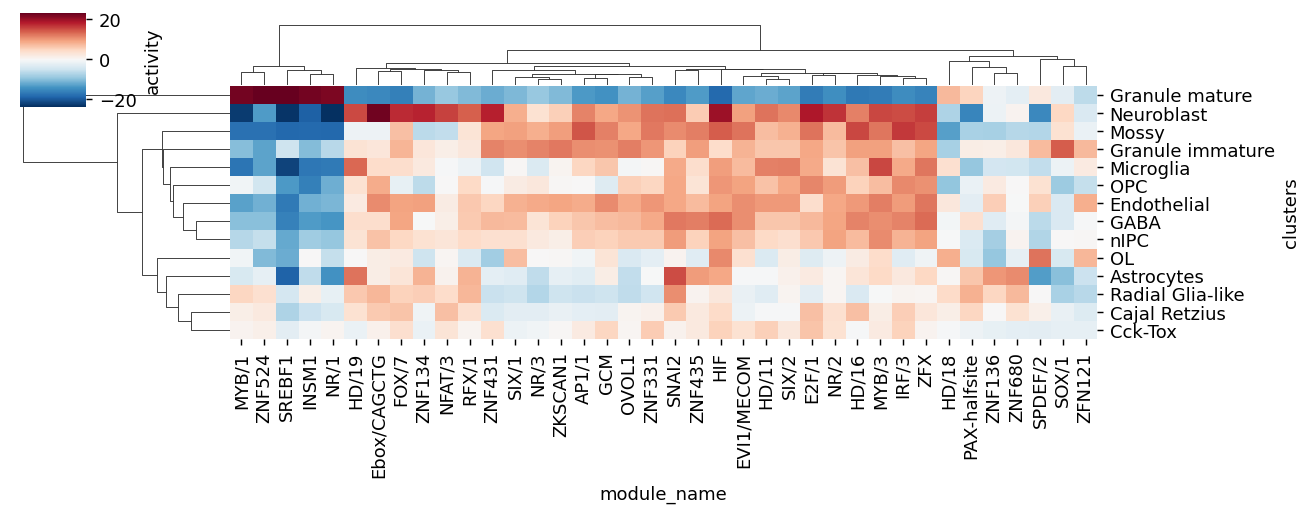

In [144]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby(cell_type_key).head(5)['module_name'])
best = rkg_df[rkg_df['module_name'].isin(mod_names_best)]
rcParams['figure.dpi'] = 130
sns.clustermap(best.pivot(index=cell_type_key, columns='module_name', values='scores'),
               cbar_kws={'label': 'activity'}, cmap='RdBu_r',
               # vmin=-5, vmax=5,
               figsize=[10.2, 4],
               # dpi=100,
               xticklabels=True)


In [145]:
rna_tfs = rna_sel.to_df()[list(set(res['gene_name']))]
rna_tfs[cell_type_key] = rna_sel.obs[cell_type_key]
mean_tfs = rna_tfs.groupby(cell_type_key).mean()

act_tfs_df = ad_act.to_df()
act_tfs_df[cell_type_key] = ad_act.obs[cell_type_key]
mean_act_tf = act_tfs_df.groupby(cell_type_key).mean()

In [146]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype,
                    columns=['module_name', 'gene_name', 'cell_type', 'pearsonr', 'p_val'])
corr = corr.sort_values('pearsonr', ascending=False)


0 288
50 288
100 288
150 288
200 288
250 288


In [147]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

In [148]:
corr[corr['pearsonr'] > 0].sort_values('p_val')

,module_name,gene_name,cell_type,pearsonr,p_val
535,CPEB1,Cpeb1,Granule mature,0.782779,0.000933
352,ZIC/2,Zic1,Endothelial,0.727187,0.003209
233,TATA,Tbp,Radial Glia-like,0.718467,0.003795
688,CCAAT/CEBP,Dbpht2,Granule mature,0.701853,0.005143
312,NR/11,Nr6a1,Cck-Tox,0.685091,0.006856
...,...,...,...,...,...
548,FOX/7,Foxo6,Endothelial,0.006682,0.981913
49,HD/2,Arxes2,Cck-Tox,0.005040,0.986358
509,GC-tract,Taf1a,Endothelial,0.003260,0.991176
240,NFKB/1,Relb,Radial Glia-like,0.001938,0.994753


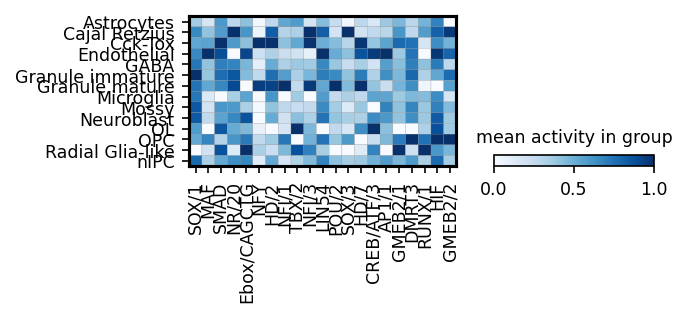

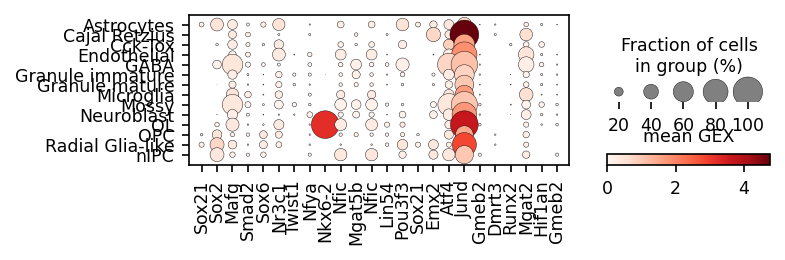

In [149]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 150
# repressors
module_names = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])
# activators

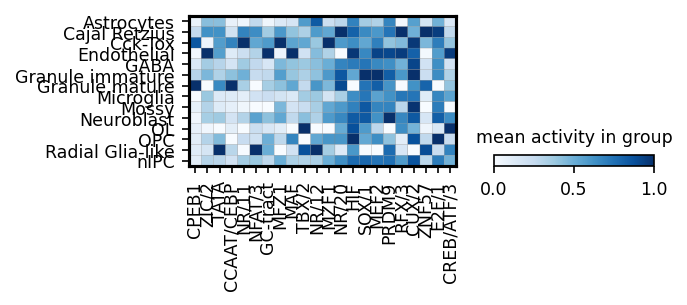

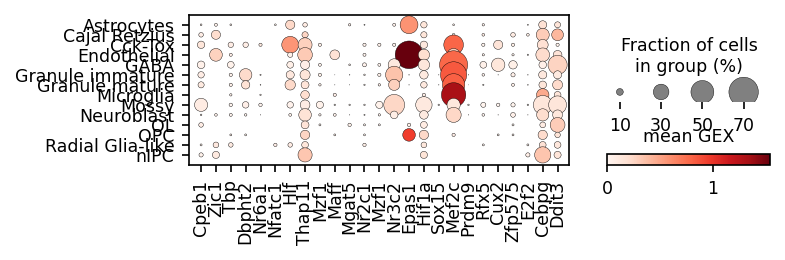

In [150]:

module_names = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])



In [168]:
filter_id_by_name = {v: k for k, v in zip(name_by_filter_id.keys(), name_by_filter_id.values())}

535     22
352    109
233    181
688     51
312     39
625    101
499    112
82     198
515     54
655     70
665     40
470    113
693    247
338     59
220     88
129    182
140    130
576    245
33      15
606    217
215    185
656     50
Name: module_name, dtype: int64


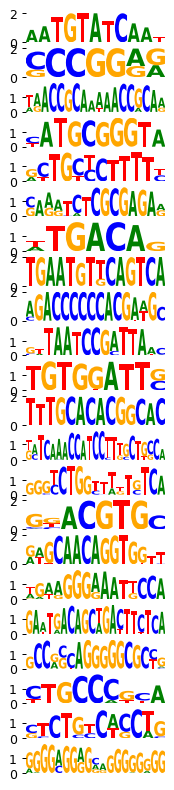

In [169]:
print(module_names.map(res.set_index('module_name')['filter_id'].to_dict()))
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    log_odds=True,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=module_names.map(filter_id_by_name) + 2,
)  # n_cols=len(reduced_groups))
# plt.tight_layout()

plt.savefig('../../../output/motif_dentategyrus_publication.pdf')
plt.show()


In [172]:
delta_model

HD/1    0.037209
HD/2    0.010972
HD/3    0.105572
HD/4    0.030862
HD/5    0.075392
          ...   
NaN     0.037915
NaN     0.000276
NaN     0.086250
NaN     0.294980
NaN     0.019049
Length: 2928, dtype: float32

In [177]:
def delta_models(model_by_logdynamic, func='mean'):
    model = model_by_logdynamic[True]
    model = model_by_logdynamic[True]
    
    log_act1 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    if func == 'expsum':
        log_act1 = log_act1.exp() / log_act1.exp().sum()
    log_act1 = pd.DataFrame(log_act1.detach().cpu().numpy())

    model = model_by_logdynamic[False]
    log_act2 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0)
    if func == 'expsum':
        log_act2 = log_act2.exp() / log_act2.exp().sum()
    log_act2 = pd.DataFrame(log_act2.detach().cpu().numpy())

    d = None
    if func == 'mean':
        d = log_act1.mean(axis=0) - log_act2.mean(axis=0)
        d = pd.DataFrame(d, columns=['delta'])
        d['graph_on'] = log_act1.mean(axis=0)
        d['graph_off'] = log_act2.mean(axis=0)
        return d
    elif func == 'abssum' or func == 'expsum':
        d = log_act1.abs().sum(axis=0) - log_act2.abs().sum(axis=0)
        d = pd.DataFrame(d, columns=['delta'])
        d['graph_on'] = log_act1.abs().sum(axis=0)
        d['graph_off'] = log_act2.abs().sum(axis=0)
        return d


# graph = True - graph = False
delta_model = delta_models(model_by_logdynamic, func='expsum')
delta_model
delta_model = delta_model[2:]
delta_model.index = range(len(delta_model))
delta_model.index += 1
delta_model.index = delta_model.index.map(name_by_filter_id)
delta_model
n_select = 20
top_delta = delta_model.sort_values('delta', ascending=False).reset_index()['index'][:n_select]
bar_df = delta_model.sort_values('delta', ascending=False).reset_index().melt(id_vars='index', value_vars=['graph_on', 'graph_off'])


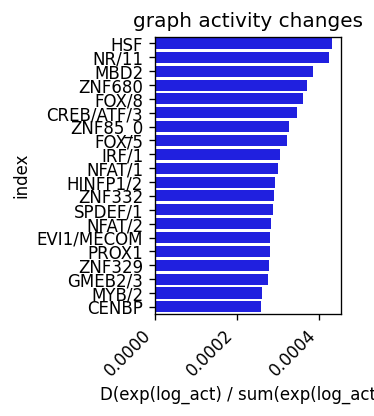

In [182]:
rcParams['figure.dpi'] = 120
rcParams['figure.figsize'] = 2, 3

motifs = delta_model.sort_values('delta', ascending=0).reset_index().head(20)
sns.barplot(data=motifs, x='delta', y='index', color='blue')
plt.title('graph activity changes')
plt.xticks(rotation=45, ha='right')
plt.xlabel('D(exp(log_act) / sum(exp(log_act)))')
plt.savefig('../../../output/delta_log_act_exp_dentate_gyrus.pdf')
plt.show()

0     248.0
1      39.0
2     238.0
3       NaN
4     202.0
5      50.0
6       NaN
7      79.0
8     103.0
9      99.0
10      NaN
11      NaN
12      NaN
13     98.0
14    240.0
15    237.0
16      NaN
17    277.0
18    253.0
19    199.0
Name: index, dtype: float64


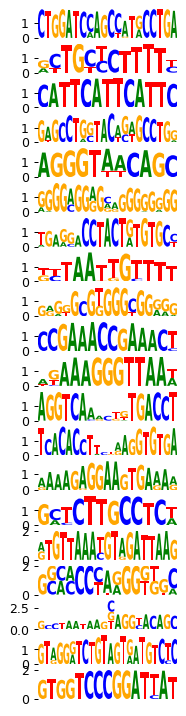

In [188]:
module_names = motifs['index']
print(motifs['index'].map(res.set_index('module_name')['filter_id'].to_dict()))
mb.pl.set_rcParams({"figure.figsize": [2, 20], "figure.dpi": 90})
mb.pl.logo(
    model,
    title=False,
    xticks=False,
    rowspan_dinuc=0,
    rowspan_mono=1,
    n_rows=40,
    log_odds=True,
    # stop_at=11,
    show=False,
    # n_rows=len(res.head(20).index),
    n_cols=1,
    order=module_names.map(filter_id_by_name) + 2,
)  # n_cols=len(reduced_groups))
# plt.tight_layout()

plt.savefig('../../../output/motif_dentategyrus_publication_fig1.pdf')
plt.show()


## Filter activities versus graph activities

In [151]:
A = model.get_log_activities()
sum_A = A.abs().sum(axis=1).cpu().detach().numpy()
A = A.squeeze(0)
print(A.shape)

torch.Size([288, 2930])


In [154]:
# this function assesses the contributions of A on the graph
indices, contributions, max_eig = mb.tl.compute_contributions(A.cpu(), C.cpu(), D.cpu())

contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=['index'])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



,index
count,288.000000
mean,0.269337
std,0.022807
min,0.204156
25%,0.253737
50%,0.267314
75%,0.283786
max,0.355356


In [155]:
contributions.shape

torch.Size([288])

Percentage of non-zero entries of the filter matrix A: 100.0 %


<Figure size 1000x500 with 0 Axes>

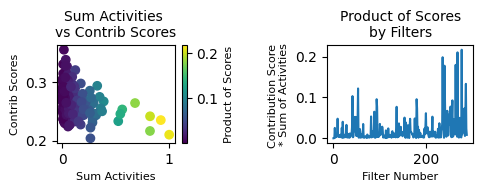

In [156]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 5))

print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")
mb.pl.filter_contrib_simple(contributions_normalized, A.cpu())

In [157]:
# normalize the data, and look at summary stats
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A.T, columns=['sum_A'])
sum_A_df.describe()

,sum_A
count,288.000000
mean,10.922637
std,18.310072
min,0.000380
25%,1.822716
50%,4.623916
75%,12.069072
max,133.253357


In [158]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.cpu().abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=['contribution_times_activities'])
contrib_times_activities_df.describe()

,contribution_times_activities
count,288.000000
mean,2.795332
std,4.376876
min,0.000109
25%,0.500195
50%,1.247980
75%,3.171744
max,28.880850


In [160]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 60

# unsqueeze the data to make it compatible with the heatmap function
sum_A_norm = sum_A_norm.reshape(1,-1)
contrib_times_activities = contrib_times_activities.reshape(1,-1)


# # only plotting filters, that are within the top 25% of the maximum contribution score
# mb.pl.contrib_heatmaps(contributions_normalized,
#                        sum_A.reshape(1, -1),
#                        contrib_times_activities,
#                        cmap='Reds')
#                        # (0.66, 11.85, 6.49),
#                        # (0.66, 11.85, 6.49)) # vmin values come from the describe() functions

# # plotting top 25% of filters normalized
# mb.pl.contrib_heatmaps(contributions_normalized,
#                        sum_A_norm,
#                        contrib_times_activities_norm.reshape(1,-1),
#                        cmap='Reds')
#                        # vmins=(0.66, 0.14, 0.19),
#                        # centers=(0.66, 0.14, 0.19)) # vmin values come from the describe() functions

# # plotting all filter
# mb.pl.contrib_heatmaps(contributions_normalized,
#                        sum_A.reshape(1, -1),
#                        contrib_times_activities,
#                        cmap='Reds')

# # plotting all filters normalized
# mb.pl.contrib_heatmaps(contributions_normalized,
#                        sum_A_norm,
#                        contrib_times_activities,
#                        cmap='Reds')

SOX/4:Sox2 (0.29021904511666824, -0.17945499298490714) 0.15828736126422882
SOX/4:Sox4 (0.2867422796585311, 0.17730515846715744) 0.15828736126422882
SOX/4:Sox9 (0.20711017691405556, -0.12806518376584686) 0.15828736126422882
SOX/4:Sox9 (0.19266754332544428, -0.11913467850460215) 0.15828736126422882
SOX/3:Sox9 (0.18181930236206786, -0.20368781889738624) 0.07002270966768265
NFKB/1:Rell2 (0.17373504894589661, -0.15685914297322734) 0.26288485527038574
SOX/4:Sox10 (0.17073008908798273, -0.10556980134532477) 0.15828736126422882
NR/20:Nr3c2 (0.17041615393082601, 0.12776960416018712) 0.17156168818473816
SOX/4:Sox12 (0.1641707649287703, 0.10151388740451499) 0.15828736126422882
SOX/4:Sox21 (0.1572416991001044, -0.09722934619125544) 0.15828736126422882


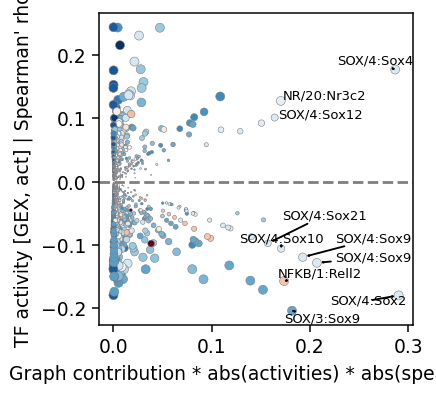

In [161]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 135
from adjustText import adjust_text

def delta_models(model_by_logdynamic):
    model = model_by_logdynamic[True]
    log_act1 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act1 = pd.DataFrame(log_act1.detach().cpu().numpy())

    model = model_by_logdynamic[False]
    log_act2 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act2 = pd.DataFrame(log_act2.detach().cpu().numpy())

    d = log_act1.mean(axis=0) - log_act2.mean(axis=0)
    # d.index = ad.obs_names
    return d

# graph = True - graph = False
delta_model = delta_models(model_by_logdynamic)
delta_model
delta_model = delta_model[2:]
delta_model.index = range(len(delta_model))
delta_model.index += 1
delta_model.index = delta_model.index.map(name_by_filter_id)
delta_model

res['act_change'] = res['module_name'].map(delta_model.to_dict())
res['k'] = res['module_name'] + ':' + res['gene_name']
res['graph_score'] = res['filter_id'].map({i : contrib_times_activities[0][i + 2] for i in range(len(contrib_times_activities[0]) - 2)})
res['z'] = np.sqrt((res['graph_score'] ** 2) * (-np.log(res['p_adj'] + 1e-10)) ** 2)


ax = plt.subplot()
cmap = sns.color_palette('RdBu_r', as_cmap=True)

res_sel = res.sort_values('z', ascending=False)
res_sel = res_sel.sort_values('z', ascending=False) # .drop_duplicates('module_name')
# res_sel = res_sel.drop_duplicates('module_name')

# res_sel['x'] = np.log((res_sel['graph_score'] + 1) * (res_sel['act_change'].abs() + 1))
res_sel['x'] = res_sel['graph_score'] * res_sel['act_change'].abs() * res_sel['spearman'].abs()
plt.scatter(res_sel['x'],            
            res_sel['spearman'],
            s=-np.log(res_sel['p_adj'] + 1e-10),
            cmap=cmap,
            lw=.3,
            edgecolors='gray',
            c=res_sel['act_change'])
plt.axhline(y=0, ls='--', c='gray')
plt.xlabel('Graph contribution * abs(activities) * abs(spearman)')
plt.ylabel('TF activity [GEX, act] | Spearman\' rho')


res_sel = res_sel.sort_values('x', ascending=False) # .drop_duplicates('module_name')
texts = [] # [plt.text(x[i], y[i], 'Text%s' %i, ha='center', va='center') for i in range(len(x))]

for ri, r in res_sel.head(10).iterrows():
    print(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), r['act_change'])
    t = ax.annotate(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), fontsize=7)
    texts.append(t)
adjust_text(texts, arrowprops=dict(arrowstyle='->'))

In [162]:
def running_mean(y_in, x_in, N_out=101, sigma=.05):
    '''
    Returns running mean as a Bell-curve weighted average at evenly spaced
    points. Does NOT wrap signal around, or pad with zeros.
    
    Arguments:
    y_in -- y values, the values to be smoothed and re-sampled
    x_in -- x values for array
    
    Keyword arguments:
    N_out -- NoOf elements in resampled array.
    sigma -- 'Width' of Bell-curve in units of param x .
    '''
    import numpy as np
    N_in = len(y_in)

    # Gaussian kernel
    x_out = np.linspace(np.min(x_in), np.max(x_in), N_out)
    x_in_mesh, x_out_mesh = np.meshgrid(x_in, x_out)
    gauss_kernel = np.exp(-np.square(x_in_mesh - x_out_mesh) / (2 * sigma**2))
    # Normalize kernel, such that the sum is one along axis 1
    normalization = np.tile(np.reshape(np.sum(gauss_kernel, axis=1), (N_out, 1)), (1, N_in))
    gauss_kernel_normalized = gauss_kernel / normalization
    # Perform running average as a linear operation
    y_out = gauss_kernel_normalized @ y_in

    return y_out, x_out

def plot_pseudotime(rna, gene_name, filter_name, sigma_gex=.05, sigma_filter=.1):
    rcParams['figure.figsize'] = 3, 2
    gene_key = gene_name
    x = rna.obs['velocity_pseudotime']
    y = rna[:,rna.var_names==gene_key].X.A.flatten()
    y = np.log(y)
    y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_gex)
    plt.scatter(x, y, edgecolors=None, color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='green')
    plt.ylabel('')
    plt.title(gene_key)
    plt.ylabel('gene expression [log]')
    plt.xlabel('pseudotime')


    x = ad.obs['velocity_pseudotime']

    plt.show()
    filter_id = int(res[res['module_name'].str.contains(filter_name)]['filter_id'].values[0])

    y= act.T.numpy()[:,filter_id]
    # y = np.abs(y)
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_filter)
    # plt.scatter(x, y, edgecolors='black', color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='blue')
    plt.ylabel('')
    plt.title('filter activities %s' % filter_name)
    plt.ylabel('filter activity')
    plt.xlabel('pseudotime')


In [163]:
scv.tl.velocity_pseudotime(rna_sample)

computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


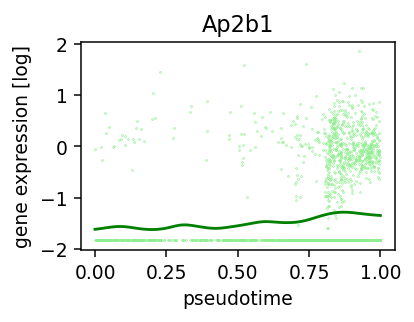

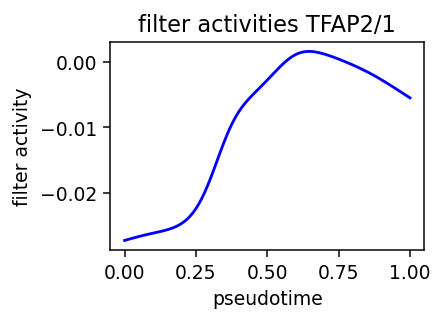

In [164]:
plot_pseudotime(rna_sample, 'Ap2b1', 'TFAP2/1', sigma_gex=.05, sigma_filter=.1)

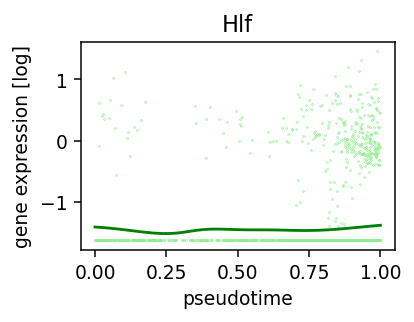

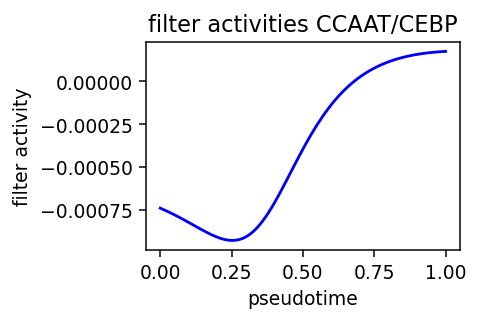

In [165]:
plot_pseudotime(rna_sample, 'Hlf', 'CCAAT/CEBP', sigma_gex=.1, sigma_filter=.2)